In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import empyrical as em
from IPython.core.display import display, HTML
import requests
import zipfile

<IPython.core.display.Javascript object>

Import the backtest results from Andreas Clenow's [website](https://www.followingthetrend.com/trading-evolved/)::

In [3]:
%%bash
cd /tmp
rm -rf trading_evolved
rm -f trading_evolved.zip

wget -q -O trading_evolved.zip https://uca2474174eba1e22341445f080c.dl.dropboxusercontent.com/cd/0/get/BDOUJlewMA7qNr7WwzfiuF43VsIqF0U-FiU578Hw_xM8pESPpuL1uqKHF9IZDiEnVKhlS1SYRNZLSCo1k5RHvuBEwSzmBuvkBD8Jv8CzxNGbWINPw3yNKmi_UF4HHXAcsvY/file
unzip -q -d trading_evolved trading_evolved.zip
ls -lah trading_evolved/Backtests

total 1.2M
drwxr-xr-x  2 root root 4.0K Jul 15  2019 .
drwxr-xr-x 20 root root 4.0K Nov 14 19:33 ..
-rw-r--r--  1 root root 165K Mar 27  2019 SPXTR.csv
-rw-r--r--  1 root root 202K Mar 27  2019 core_trend.csv
-rw-r--r--  1 root root 201K Mar 27  2019 counter_trend.csv
-rw-r--r--  1 root root 201K Mar 28  2019 curve_trading.csv
-rw-r--r--  1 root root 165K Mar 27  2019 equity_momentum.csv
-rw-r--r--  1 root root 201K Mar 27  2019 time_return.csv


<IPython.core.display.Javascript object>

In [4]:
DATA_FOLDER = "/tmp/trading_evolved"
base_path = f"{DATA_FOLDER}/Backtests/"

<IPython.core.display.Javascript object>

Pick a benchmark and a strategy:

In [5]:
bm = "SPXTR"
bm_name = "S&P 500 Total Return Index"

strat_names = {
    "core_trend": "Core Trend Strategy",
    "time_return": "Time Return Strategy",
    "counter_trend": "Counter Trend Strategy",
    "curve_trading": "Curve Trading Strategy",
    "equity_momentum": "Equity Momentum Strategy",
}

strat = "curve_trading"
strat_name = strat_names[strat]

<IPython.core.display.Javascript object>

In [6]:
df = pd.read_csv(
    base_path + strat + ".csv", index_col=0, parse_dates=True, names=[strat]
)
df[bm_name] = pd.read_csv(base_path + bm + ".csv", index_col=0, parse_dates=[0])
df = df.loc[:"2018-12-31"].dropna()

df.head(5)

,curve_trading,S&P 500 Total Return Index
2001-01-02,1.000000e+06,1785.8598
2001-01-03,1.003475e+06,1875.5640
2001-01-04,1.014192e+06,1855.8183
2001-01-05,1.017504e+06,1807.1283
2001-01-08,1.015294e+06,1804.0384


<IPython.core.display.Javascript object>

Compare strategy to benchmark:

/usr/local/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)
findfont: Font family ['eurostile'] not found. Falling back to DejaVu Sans.
findfont: Font family ['eurostile'] not found. Falling back to DejaVu Sans.


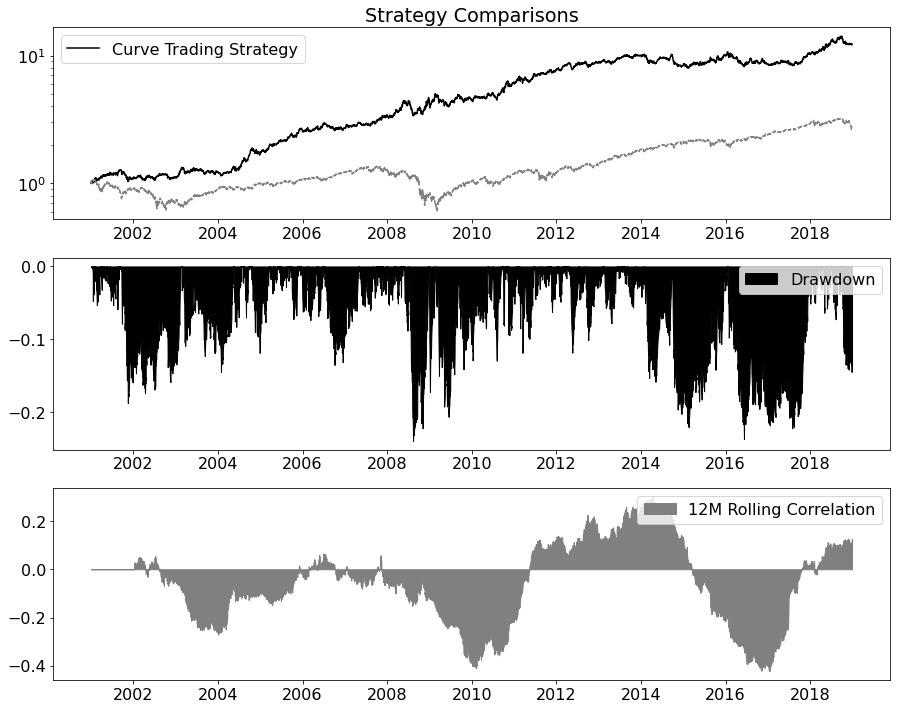

<IPython.core.display.Javascript object>

In [7]:
yr_periods = 252

# Format for book display
font = {"family": "eurostile", "weight": "normal", "size": 16}
matplotlib.rc("font", **font)


def equity_graph(df):
    df = df / df.iloc[0]
    df["Correlation"] = (
        df[strat]
        .pct_change()
        .rolling(window=int(yr_periods / 1))
        .corr(df[bm_name].pct_change())
    )

    df["Drawdown"] = (df[strat] / df[strat].cummax()) - 1

    df.fillna(0, inplace=True)  # make sure no NA values are in there
    fig = plt.figure(figsize=(15, 12))

    # First chart
    ax = fig.add_subplot(311)
    ax.set_title("Strategy Comparisons")
    ax.semilogy(df[strat], "-", label=strat_name, color="black")
    ax.semilogy(df[bm_name], "--", color="grey")
    ax.legend()

    # Second chart
    ax = fig.add_subplot(312)
    ax.fill_between(df.index, df["Drawdown"], label="Drawdown", color="black")
    ax.legend()

    # Third chart
    ax = fig.add_subplot(313)
    ax.fill_between(
        df.index, df["Correlation"], label="12M Rolling Correlation", color="grey"
    )
    ax.legend()


equity_graph(df)

Monthly return table:

In [8]:
monthly_data = em.aggregate_returns(df[strat].pct_change(), "monthly")
yearly_data = em.aggregate_returns(df[strat].pct_change(), "yearly")

table = """
<table class='table table-hover table-condensed table-striped'>
<thead>
<tr>
<th style="text-align:right">Year</th>
<th style="text-align:right">Jan</th>
<th style="text-align:right">Feb</th>
<th style="text-align:right">Mar</th>
<th style="text-align:right">Apr</th>
<th style="text-align:right">May</th>
<th style="text-align:right">Jun</th>
<th style="text-align:right">Jul</th>
<th style="text-align:right">Aug</th>
<th style="text-align:right">Sep</th>
<th style="text-align:right">Oct</th>
<th style="text-align:right">Nov</th>
<th style="text-align:right">Dec</th>
<th style="text-align:right">Year</th>
</tr>
</thead>
<tbody>
<tr>"""

first_year = True
first_month = True
yr = 0
mnth = 0
for m, val in monthly_data.iteritems():
    yr = m[0]
    mnth = m[1]

    if first_month:
        table += "<td align='right'><b>{}</b></td>\n".format(yr)
        first_month = False

    if first_year:  # pad empty months for first year if sim doesn't start in January
        first_year = False
        if mnth > 1:
            for i in range(1, mnth):
                table += "<td align='right'>-</td>\n"

    table += "<td align='right'>{:+.1f}</td>\n".format(val * 100)

    if mnth == 12:  # check for dec, add yearly
        table += "<td align='right'><b>{:+.1f}</b></td>\n".format(yearly_data[yr] * 100)
        table += "</tr>\n <tr> \n"
        first_month = True

# add padding for empty months and last year's value
if mnth != 12:
    for i in range(mnth + 1, 13):
        table += "<td align='right'>-</td>\n"
        if i == 12:
            table += "<td align='right'><b>{:+.1f}</b></td>\n".format(
                yearly_data[yr] * 100
            )
            table += "</tr>\n <tr> \n"
table += "</tr>\n </tbody> \n </table>"

display(HTML(table))

Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year
2001,+4.2,+1.4,+5.8,+2.5,+2.7,+2.5,-3.0,+7.7,-3.1,-7.0,-2.3,-0.1,+10.7
2002,+0.6,+3.0,-6.0,+6.1,-2.1,-1.0,+4.1,+0.8,+0.9,-3.7,-2.6,+2.2,+1.7
2003,+5.1,+11.4,-5.5,-1.5,+5.6,+0.3,-0.8,-3.8,+0.3,-0.3,-2.0,+0.1,+8.1
2004,-4.2,+4.2,-0.3,+5.3,-0.5,+3.1,+15.3,-2.1,+12.9,+11.7,-2.0,-5.7,+41.2
2005,+5.7,-0.6,+10.6,-0.2,+3.5,+4.5,+0.5,+6.0,+4.3,-0.2,+7.3,+1.2,+51.1
2006,-1.6,+0.4,+3.1,+3.1,-1.2,+7.5,-1.5,-4.7,-0.7,-1.9,+1.2,+1.0,+4.2
2007,+1.2,+2.5,+1.1,+4.8,-2.6,+0.4,-1.6,+5.3,+1.9,+5.1,+2.2,+2.0,+24.2
2008,-1.0,+3.8,+5.2,+2.7,+15.2,-1.1,-11.4,-4.5,+5.9,-6.8,+8.9,+9.7,+26.3
2009,+5.9,+6.0,-5.4,+0.1,-6.7,+1.2,+1.6,+10.5,-1.3,-4.8,+0.8,+0.8,+7.3
2010,+6.4,-3.0,+0.4,-1.6,+6.0,+3.0,-8.3,+6.8,+7.9,+14.3,-5.2,+6.6,+36.1


<IPython.core.display.Javascript object>

Holding period returns:

In [9]:
def holding_period_map(df):
    yr = em.aggregate_returns(df[strat].pct_change(), 'yearly')
    df = pd.DataFrame(columns=range(1,len(yr)+1), index=yr.index)

    yr_start = 0
    
    table = "<table class='table table-hover table-condensed table-striped'>"
    table += "<tr><th>Years</th>"
    
    for i in range(len(yr)):
        table += "<th>{}</th>".format(i+1)
    table += "</tr>"

    for the_year, value in yr.iteritems(): # Iterates years
        table += "<tr><th>{}</th>".format(the_year) # New table row
        
        for yrs_held in (range(1, len(yr)+1)): # Iterates yrs held 
            if yrs_held   <= len(yr[yr_start:yr_start + yrs_held]):
                ret = em.annual_return(yr[yr_start:yr_start + yrs_held], 'yearly' )
                table += "<td>{:+.0f}</td>".format(ret * 100)
        table += "</tr>"    
        yr_start+=1
    return table

table = holding_period_map(df)
display(HTML(table))


<IPython.core.display.Javascript object>